## Libraray Import

In [1]:
import pandas as pd; pd.options.mode.chained_assignment = None
import numpy as np

# Built In Imports

from datetime import datetime
from glob import glob
import warnings
import IPython
import urllib
import zipfile
import pickle
import shutil
import string
import math
import tqdm
import time
import os
import gc
import re
import argparse
from pycocotools.coco import COCO
import pandas as pd
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path

# Visualization Imports

from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from PIL import Image
import matplotlib
import plotly
import PIL
import cv2
import mmcv
from mmcv import Config
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
from mmdet.models import build_detector
from mmdet.apis import single_gpu_test
from mmcv.runner import load_checkpoint
import os
from mmcv.parallel import MMDataParallel
import pandas as pd
from pandas import DataFrame
from pycocotools.coco import COCO
import numpy as np
from pycocotools.coco import COCO

# Other Imports

from tqdm.notebook import tqdm

LABELCOLORS = [px.colors.label_rgb(px.colors.convert_to_RGB_255(x)) for x in sns.color_palette("Spectral", 10)]
LABELCOLORSWOUTNOFINDING = LABELCOLORS[:8]+LABELCOLORS[9:]

/opt/conda/envs/project2/lib/python3.7/site-packages/mmcv/__init__.py:21: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  'On January 1, 2023, MMCV will release v2.0.0, in which it will remove '


## Submission to Json

In [22]:
gt_json='/opt/ml/dataset/2___train_MultiStfKFold.json'
pred_csv=f'/opt/ml/baseline/baseline_cv11/UniverseNet/work_dirs/universenet101_2008d_fp16_4x4_mstrain_480_960_20e_coco_trash/correlation_{epoch}.csv'
file_name='confusion_matrix.png'

In [23]:
def box_iou_calc(boxes1, boxes2):
    
    def box_area(box):
        # box = 4xn
        return (box[2] - box[0]) * (box[3] - box[1])

    area1 = box_area(boxes1.T)
    area2 = box_area(boxes2.T)

    lt = np.maximum(boxes1[:, None, :2], boxes2[:, :2])  # [N,M,2]
    rb = np.minimum(boxes1[:, None, 2:], boxes2[:, 2:])  # [N,M,2]

    inter = np.prod(np.clip(rb - lt, a_min=0, a_max=None), 2)
    return inter / (area1[:, None] + area2 - inter)  # iou = inter / (area1 + area2 - inter)

class ConfusionMatrix:
    def __init__(self, num_classes: int, CONF_THRESHOLD=0.3, IOU_THRESHOLD=0.5):
        self.matrix = np.zeros((num_classes + 1, num_classes + 1))
        self.num_classes = num_classes
        self.CONF_THRESHOLD = CONF_THRESHOLD
        self.IOU_THRESHOLD = IOU_THRESHOLD

    def plot(self, file_name='./', names=["General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]):
        try:
            import seaborn as sn

            array = self.matrix / (self.matrix.sum(0).reshape(1, self.num_classes + 1) + 1E-6)  # normalize
            array[array < 0.005] = np.nan  # don't annotate (would appear as 0.00)

            fig = plt.figure(figsize=(12, 9), tight_layout=True)
            sn.set(font_scale=1.0 if self.num_classes < 50 else 0.8)  # for label size
            labels = (0 < len(names) < 99) and len(names) == self.num_classes  # apply names to ticklabels
            sn.heatmap(array, annot=self.num_classes < 30, annot_kws={"size": 8}, cmap='Blues', fmt='.2f', square=True,
                       xticklabels=names + ['background FP'] if labels else "auto",
                       yticklabels=names + ['background FN'] if labels else "auto").set_facecolor((1, 1, 1))
            fig.axes[0].set_xlabel('True')
            fig.axes[0].set_ylabel('Predicted')
            
            # if not Path('./result_analysis').exists():
            #     Path('./result_analysis').mkdir(parents=True, exist_ok=True)
            #     fig.savefig(Path('./result_analysis') / file_name, dpi=150)
        except Exception as e:
            print(e)
            pass

    def process_batch(self, detections, labels: np.ndarray):
        """
        Return intersection-over-union (Jaccard index) of boxes.
        Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
        Arguments:
            detections (Array[N, 6]), x1, y1, x2, y2, conf, class
            labels (Array[M, 5]), class, x1, y1, x2, y2
        Returns:
            None, updates confusion matrix accordingly
        """
        gt_classes = labels[:, 0].astype(np.int16)

        try:
            detections = detections[detections[:, 4] > self.CONF_THRESHOLD]
        except IndexError or TypeError:
            # detections are empty, end of process
            for i, label in enumerate(labels):
                gt_class = gt_classes[i]
                self.matrix[self.num_classes, gt_class] += 1
            return

        detection_classes = detections[:, 5].astype(np.int16)

        all_ious = box_iou_calc(labels[:, 1:], detections[:, :4])
        want_idx = np.where(all_ious > self.IOU_THRESHOLD)

        all_matches = [[want_idx[0][i], want_idx[1][i], all_ious[want_idx[0][i], want_idx[1][i]]]
                       for i in range(want_idx[0].shape[0])]

        all_matches = np.array(all_matches)
        if all_matches.shape[0] > 0:  # if there is match
            all_matches = all_matches[all_matches[:, 2].argsort()[::-1]]

            all_matches = all_matches[np.unique(all_matches[:, 1], return_index=True)[1]]

            all_matches = all_matches[all_matches[:, 2].argsort()[::-1]]

            all_matches = all_matches[np.unique(all_matches[:, 0], return_index=True)[1]]

        for i, label in enumerate(labels):
            gt_class = gt_classes[i]
            if all_matches.shape[0] > 0 and all_matches[all_matches[:, 0] == i].shape[0] == 1:
                detection_class = detection_classes[int(all_matches[all_matches[:, 0] == i, 1][0])]
                self.matrix[detection_class, gt_class] += 1
            else:
                self.matrix[self.num_classes, gt_class] += 1

        for i, detection in enumerate(detections):
            if not all_matches.shape[0] or ( all_matches.shape[0] and all_matches[all_matches[:, 1] == i].shape[0] == 0 ):
                detection_class = detection_classes[i]
                self.matrix[detection_class, self.num_classes] += 1

    def return_matrix(self):
        return self.matrix

    def print_matrix(self):
        for i in range(self.num_classes + 1):
            print(' '.join(map(str, self.matrix[i])))

def main():

    conf_mat = ConfusionMatrix(num_classes = 10, CONF_THRESHOLD = 0.01, IOU_THRESHOLD = 0.5)
    gt_path = "/opt/ml/dataset/2___val_MultiStfKFold.json"
    pred_path = "/opt/ml/level2_objectdetection-cv-11/eda/submission_best_bbox_mAP_50_epoch_20_val.csv"
    with open(gt_path, 'r') as outfile:
        test_anno = (json.load(outfile))

    pred_df = pd.read_csv(pred_path)

    new_pred = []

    gt = []

    file_names = pred_df['image_id'].values.tolist()
    bboxes = pred_df['PredictionString'].values.tolist()
    for i, bbox in enumerate(bboxes):
        if isinstance(bbox, float):
            print(f'{file_names[i]} empty box')

    for file_name, bbox in tqdm(zip(file_names, bboxes)):
        new_pred.append([])
        boxes = np.array(str(bbox).split(' '))

        if len(boxes) % 6 == 1:
            boxes = boxes[:-1].reshape(-1, 6)
        elif len(boxes) % 6 == 0:
            boxes = boxes.reshape(-1, 6)
        else:
            raise Exception('error', 'invalid box count')
        for box in boxes:
            new_pred[-1].append([float(box[2]), float(box[3]), float(box[4]), float(box[5]),  float(box[1]), float(box[0])])

    coco = COCO(gt_path)
    
    for image_id in coco.getImgIds():
        gt.append([])
        image_info = coco.loadImgs(image_id)[0]
        ann_ids = coco.getAnnIds(imgIds=image_info['id'])
        anns = coco.loadAnns(ann_ids)
        
        file_name = image_info['file_name']
        
        for ann in anns:
            gt[-1].append([
                       float(ann['category_id']),
                       float(ann['bbox'][0]),
                       float(ann['bbox'][1]),
                       float(ann['bbox'][0]) + float(ann['bbox'][2]),
                       (float(ann['bbox'][1]) + float(ann['bbox'][3])),  
                       ]
                       )
    for p, g in zip(new_pred, gt):
        conf_mat.process_batch(np.array(p), np.array(g))
    conf_mat.plot(file_name)

0it [00:00, ?it/s]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


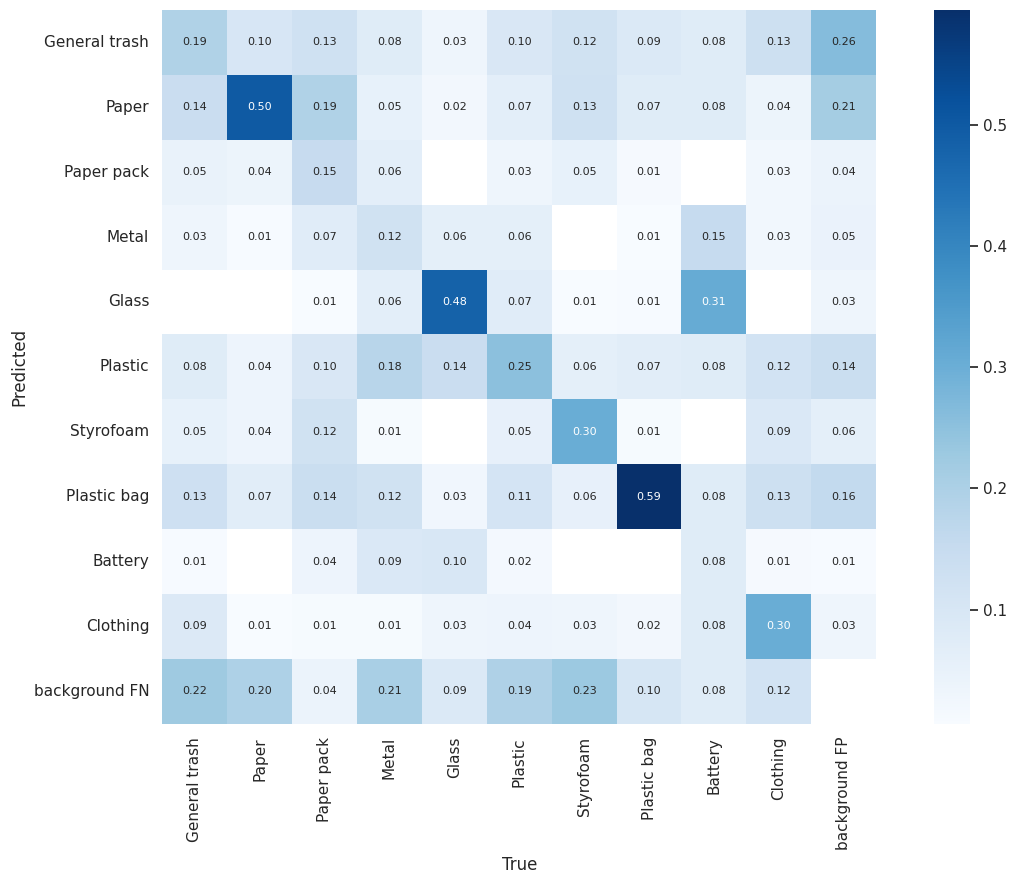

In [24]:
main()